# Introduction
To use National Instrument (NI) devices with a computer, one would usually need to use the NI-DAQmx C API provided by National Instruments either through LabVIEW, or writing programs directly in the C programming language.
Fortunately, NI devices are very common and people have written libraries for interfacing them with several languages.
The most notable case is MATLAB'S Data Acquisition Toolbox, which works not only for NI but other companies as well.

If one wants to use Python, it is possible to use the official [nidaqmx](https://github.com/ni/nidaqmx-python) package, which wraps the C API using highly object-oriented approach in Python.
Since nidaqmx simply wraps the C API, it is very powerful library and allows us to do anything that can be done from inside LabVIEW.
However, for this same reason, if one wants to write a simple read task, for example, a lot of boiler plate (repetitive and trivial code) is needed, and having to write the same configuration code over, and over again, can turn into a source of all sorts of bugs.

The modules in this repository were written to allows us at ASDL to use NI devices without much boiler plate code.
It is very different from MATLAB's Data Acquisition Toolbox, because it allows us to fallback to the bare NI-DAQmx functionality anytime we want, be it either when there is a bug in this library, or when a functionality is not facilitated.

# Requirements and goals
To follow this tutorial, you should have a device with at least one output and one input analog channels connected to your computer.
You will also need to have this repository, plus Matplotlib installed.

This tutorial will teach you how to set up a simple read and write task in a few steps:
1. set up the device
2. read the data
3. save the data to the disk

To accomplish this, we will use the following:
- `MeasuredData`: a class to create objects that can hold, save and load data.
- `SingleDevice`: an class to manage tasks that use a single NI device.
- methods straight from NI's nidaqmx library.

You should remember you can always use `help` to find out more about what each function does.

# Initial setup

First, we import what we will need to used.
Then, we create an object to hold the data and setup out output signal and other parameters.
The object will be called `data`, and we can add attributes to it storing any value that we might want to save later one.
Here we are interested in saving the sampling rate, the vector with the discretized time, and the output signal.

In [1]:
from asdl import MeasuredData
from asdl.ni import SingleDevice, available_devices
import nidaqmx as ni
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = MeasuredData()
data.sampl_rate = 20e3                                   # Sampling rate (samples/s)
data.time_vect = np.arange(0, 1, 1/data.sampl_rate)      # Time vector
data.data_out = np.sin(2 * np.pi * 20 * data.time_vect)  # Output signal (sine @ 20 Hz)

# Tasks

Every time we are managing NI devices, we call it a "task".
This name comes from National Instrument itself, is used in the official NI-DAQmx C API.
The same device can be used in different tasks, as long as they do not use the same channels simultaneously.
However, each task can only read or only write data, it cannot do both.
Therefore, we need to create two tasks for one single device, which is facilitated by the `SingleDevice` class defined in this library.
Before moving on, you can check which devices are connected to your computer using `available_devices` function:

In [3]:
available_devices()

[Device(name=Dev6)]

Now we create the tasks using `SingleDevice`.
The `task` object will have two attributes: `read_task` and `write_task`, which are responsible for reading and writing signals, respectively.
The tasks should be configured by setting up input and output channels, and by configuring the sampling clock and timing.

The methods `add_ai_voltage_chan`, `add_ao_voltage_chan` and `cfg_samp_clk_timing` simply forward the parameters to the original methods of the same name contained in nidaqmx.
There are many other methods available, but these are the ones facilitated by library.
If you want to know all possible configuration methods and functions, you can use either `help(task.read_task)` or simply list them with `dir(task.read_task)`. You can do the same for `task.write_task`, but the `help` and `dir` outputs will be the same because they are the same type of objects.

When configuring the sampling clock, notice the parameter `sample_mode=ni.constantes.FINITE`.
We are using the "official" value defined in nidaqmx library to tell this task that we want to measure only the defined number of points, which is `samps_per_chan` and is set to be equal to the size of the output signal.
After acquiring or write the given number of data points, the task will stop.
If the value for `sample_mode` were `CONTINUOUS`, task you continue (like an infinite loop) until we interrupted it.

In [4]:
task = SingleDevice('Dev6')
task.add_ai_voltage_chan(
    'Dev6/ai0',
    min_val=-3,
    max_val=+3,
)
task.add_ao_voltage_chan(
    'Dev6/ao0',
    min_val=-3,
    max_val=+3,
)
task.cfg_samp_clk_timing(
    rate=data.sampl_rate,
    sample_mode=ni.constants.AcquisitionType.FINITE,
    samps_per_chan=data.data_out.size,
)

The read and write tasks are not synchronized by default, because breaking synchronization is harder is harder than synchronizing.
Before synchronizing, it is necessary to set up the output signal.
If the output signal is not buffered by the device, an error will be throwing the NI-DAQmx.
Notice the `auto_start=False`: if not set to `False`, the output signal is written immediately.
This option, together with the following `synchronize` method, makes the writing wait for the internal trigger signal from the reading.

In [5]:
task.write_task.write(data.data_out, auto_start=False)
task.synchronize()

Now we read a signal and store it to the `data` object.
The `read` method is also from nidaqmx library, and it returns a list of float values.
You can use `help(task.read)` to learn more.

In [6]:
data.data_in = task.read(
    number_of_samples_per_channel=data.data_out.size
)

# Storing and visualizing data

We have finished acquiring data it for later usage.
For that we use `save`, a method defined for `MeasuredData` objects, to create the file "simple_read_and_write.pkl".
The extension ".pkl" means "pickle", and it refers to the binary format commonly used in Python.
You can read more about "pickle" in the official documentation: [https://docs.python.org/3/library/pickle.html](https://docs.python.org/3/library/pickle.html).

When you save a `MeasuredData` object, all its attributes are also saved.
In our case, `sampl_rate`, `data_out`, `data_in` and `time_vect` will all be stored and can be loaded later.
To load the data again, you can to the following in a new Python session or file:
```python
from asdl import MeasuredData
data = MeasuredData.load('simple_read_and_write.pkl')
```

The configuration of a task, on the other hand, cannot be saved.

In [7]:
data.save('simple_read_and_write.pkl')

We can visualize the data too.

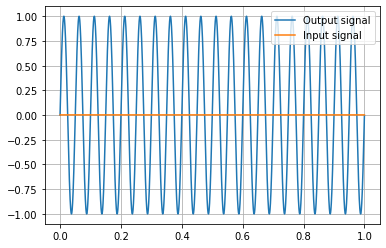

In [8]:
plt.plot(data.time_vect, data.data_out, label='Output signal')
plt.plot(data.time_vect, data.data_in, label='Input signal')
plt.legend()
plt.grid()

# Closing the task

After finishing reading or writing data, it is important to close the task.
Closing the task your computer and NI-DAQmx drivers that you will not use those resources (i.e. the device, its internal memory, etc.) anymore, and the can be used by other tasks.
Here, `close` is another function from nidaqmx library, and it is the same as doing
```python
task.read_task.close()
task.write_task.close()
```

In [9]:
task.close()

## Using `with` context manager

Another way of dealing with `SingleDevice` is using Python's `with` statement.
If you use `with` you will not have to worry about closing the task after you are done.
For example, the following exceprt
```python
with SingleDevice('Dev6') as task:
    task.add_ai_voltage_chan(...)
    data = task.read(...)
<other code that do not need to read or write data goes here>
```
is the same as
```python
task.add_ai_voltage_chan(...)
data = task.read(...)
task.close()
<other code that do not need to read or write data goes here>
```
It is recommended that you use `with` in case you only need to use the device once.
If you need to read or write data in different parts of you code, it simpler to just not use `with`.
If that is the your case, do not forget to close your tasks.
If you forget to do so, you will see warnings and errors when you re-run your script, try to re-configure the same task, or when closing your Python session.

# Closing remarks

In this short tutorial, you learned how to run a simple read and write task, and how to save and load data.
If you want to understand how these things work under the hood, you are encouraged to read the source code for the `ni` module in this package, specifically [./asdl/ni/__inti__.py](./asdl/ni/__init__.py).
You will notice that `SingleDevice` tries to be a very simple class that simply dispatches parameters to the underlying nidaqmx library, while trying to catch common errors thrown by NI-DAQmx drivers.

If you want to contribute and implement some additional functionality, just do it yourself and send a pull request to this repository when you are done.